In [5]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
import copy

# function to expand the input matrix based on expd_size
def expd(original_mat, expd_size):
    sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
    output = np.zeros([expd_size,expd_size])
    output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    return output

def loadMat(filePath, expd_size, matlab_var):
    tmp = scipy.io.loadmat(filePath)[matlab_var]
    tmp = expd(tmp, expd_size)
    tmp = tmp[0::2,0::2]
    tmp = tmp[50:150,50:150]
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=4)
    return tmp

# check and create output folder
import os
outputFolder = './data'
try:
    os.makedirs(outputFolder)
except:
    pass

# get all cases folder name
cases = glob.glob('../Matlab_simulation_data/case*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

save_freq = 1000 # 0 for per10, 00 for per 100
len_iter = int(35000/save_freq)
ignore_iter = int(500/save_freq)
expd_size = 400 # target domain size
dwn = 4 # down sample ratio
dwn_sz = int(expd_size/dwn)
numCases = len(cases)

for i in tqdm (range(len(cases)), desc="Running ..."):
    inputFolder = cases[i]
    case = inputFolder.replace('../Matlab_simulation_data/','')

    # load theta
    thetaPath = glob.glob(inputFolder+'/theta_35000.mat')
    theta_temp = np.array(scipy.io.loadmat(thetaPath[0])['theta_plot'].todense())
    thetaExpd = expd(theta_temp, expd_size)
    theta_dwn = thetaExpd[0::2,0::2]
    theta = theta_dwn[50:150,50:150]
    theta = np.expand_dims(theta,axis=0)
    theta = np.expand_dims(theta,axis=0)
    theta = np.expand_dims(theta,axis=4)

    # defined input data folder and grab a list of data files
    phiPath = glob.glob(inputFolder+'/phi*0.mat')
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    tipsPath = glob.glob(inputFolder+'/tips*0.mat')
    tipsPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    tubPath = glob.glob(inputFolder+'/conct*0.mat')
    tubPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    temprPath = glob.glob(inputFolder+'/tempr*0.mat')
    temprPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    jj=0
    for j in range(len(phiPath)):
        iter = int(phiPath[j].replace('../Matlab_simulation_data/'+case+'/phi_','').replace('.mat',''))
        if ((iter % save_freq) == 0) and (iter > 500):
            # load data
            phi_dwn = np.round(loadMat(phiPath[j], expd_size, 'phi_plot'))
            tips_dwn = loadMat(tipsPath[j], expd_size, 'theta_ori')
            tub_dwn = loadMat(tubPath[j], expd_size, 'conct_plot')
            tempr_dwn = loadMat(temprPath[j], expd_size, 'tempr_plot')
            # iter_vars = np.concatenate([phi_dwn,tips_dwn,tub_dwn,tempr_dw,theta], axis=4)

            iter_vars = copy.copy(theta)
            iter_vars[phi_dwn==1] = tub_dwn[phi_dwn==1]+2
            iter_vars = iter_vars + tips_dwn
            iter_vars = np.concatenate([iter_vars, theta], axis=4)

            if jj==0:
                # phi_case = phi_dwn
                # tips_case = tips_dwn
                # tub_case = tub_dwn
                # tempr_case = tempr_dwn
                
                phi_case = iter_vars
            else:
                # phi_case = np.append(phi_case, phi_dwn, axis=1)
                # tips_case = np.append(tips_case, tips_dwn, axis=1)
                # tub_case = np.append(tub_case, tub_dwn, axis=1)
                # tempr_case = np.append(tempr_case, tempr_dwn, axis=1)

                phi_case = np.append(phi_case, iter_vars, axis=1)
                
            jj+=1

    if i==0:
        phi_cases = phi_case
    else:
        phi_cases = np.append(phi_cases, phi_case, axis=0)

Running ...: 100%|██████████| 92/92 [00:28<00:00,  3.27it/s]


In [6]:
phi_cases.shape

(92, 35, 100, 100, 2)

In [7]:
hdf5_file = h5py.File(outputFolder+'/test_withTips_07042022.hdf5', mode='w')
hdf5_file.create_dataset("phi", (phi_cases.shape[0], phi_cases.shape[1], phi_cases.shape[2], phi_cases.shape[3], phi_cases.shape[4]), np.float64, chunks=(1, 1, phi_cases.shape[2], phi_cases.shape[3], 1), compression="gzip")
# hdf5_file.create_dataset("phi", (phi_cases.shape[0], phi_cases.shape[1], phi_cases.shape[2], phi_cases.shape[3], 1), np.float64, chunks=(1, 1, phi_cases.shape[2], phi_cases.shape[3], 1), compression="gzip")
hdf5_file["phi"][...] = phi_cases
hdf5_file.close()

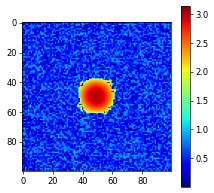

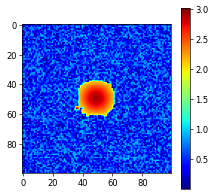

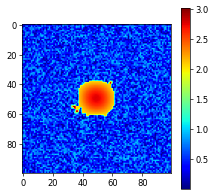

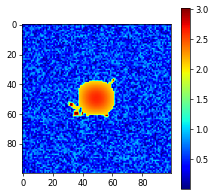

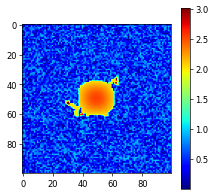

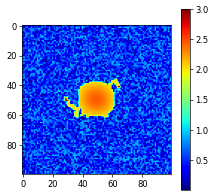

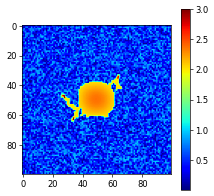

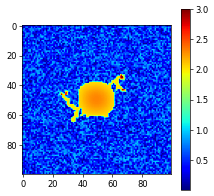

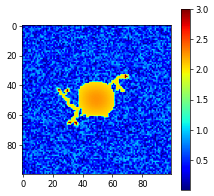

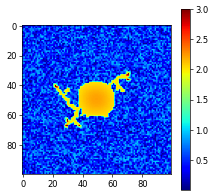

In [8]:
import matplotlib.pyplot as plt
hdf5_file = h5py.File(outputFolder+'/test_withTips_07042022.hdf5', mode='r')
ind = hdf5_file.get('phi')

id=0
numFrames=ind.shape[1]
numFrames = 10
for i in range(numFrames):
    plt.figure(figsize=(4, 4), dpi=60)
    plt.imshow(ind[id,i,:,:,0],cmap='jet')
    plt.colorbar()
    plt.show()
hdf5_file.close()

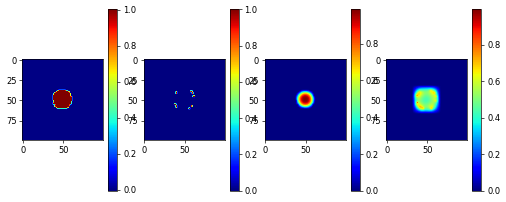

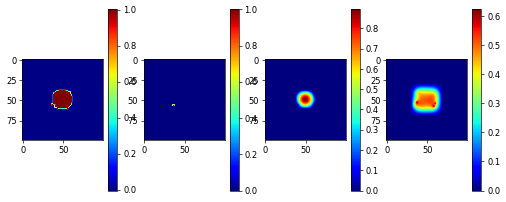

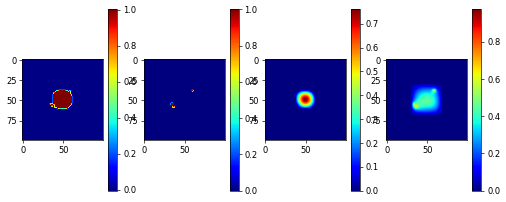

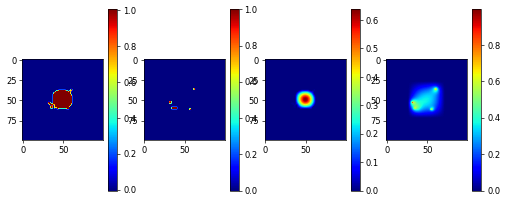

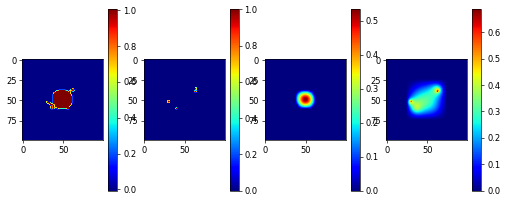

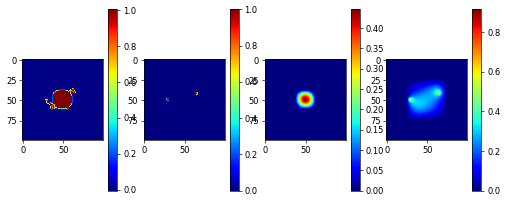

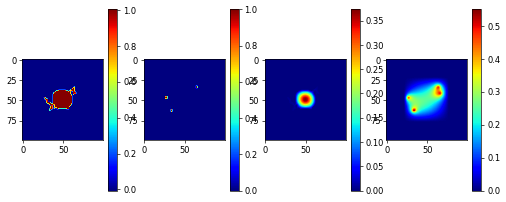

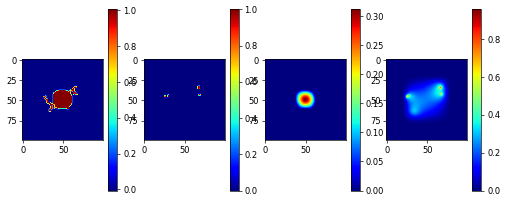

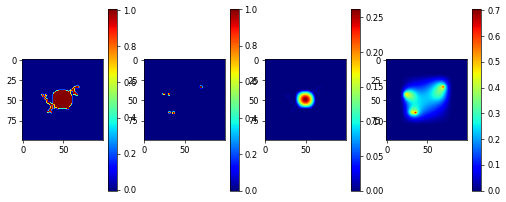

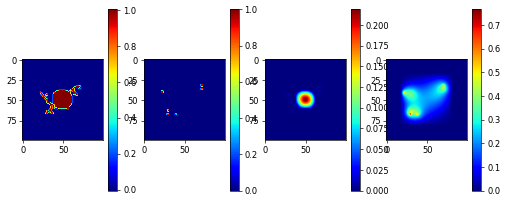

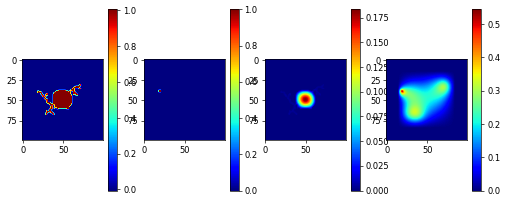

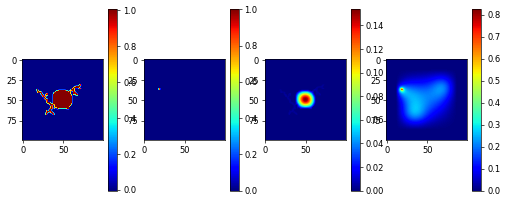

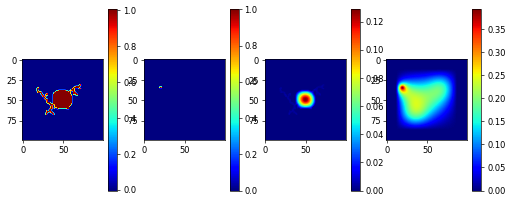

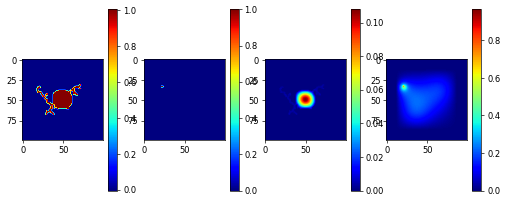

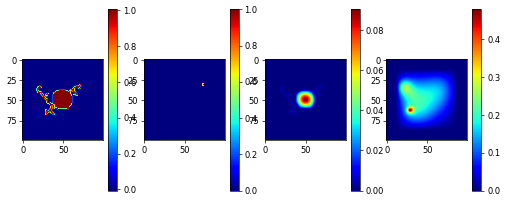

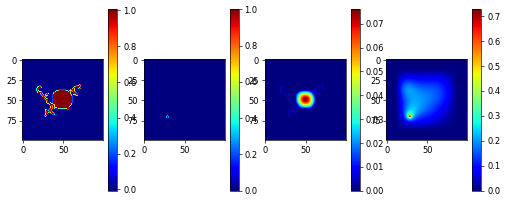

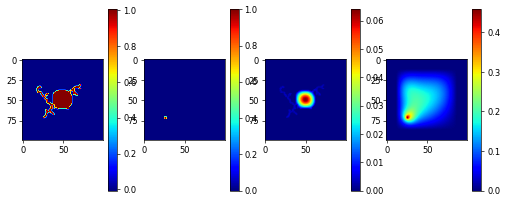

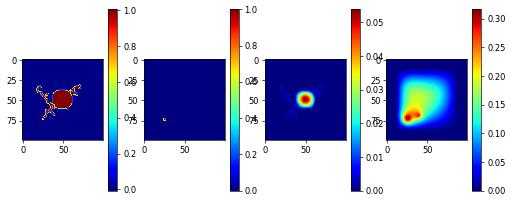

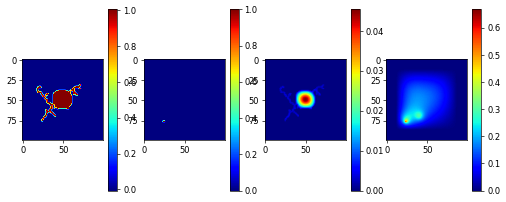

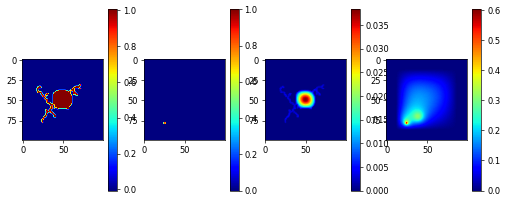

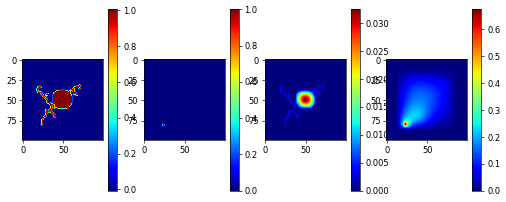

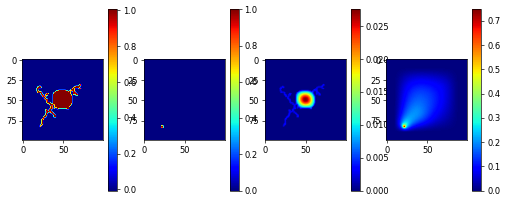

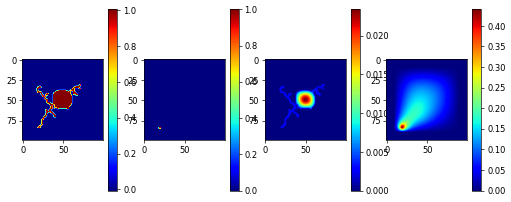

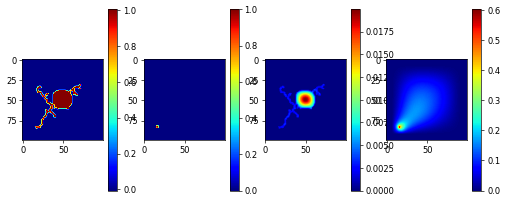

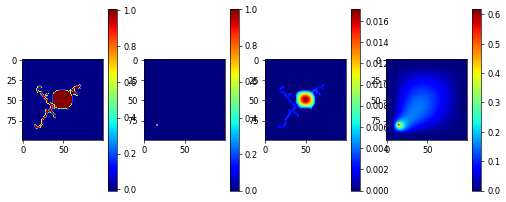

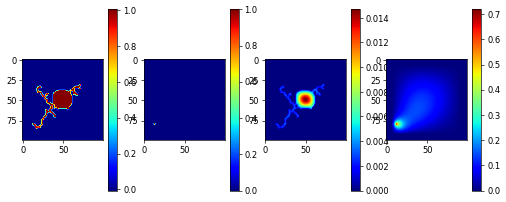

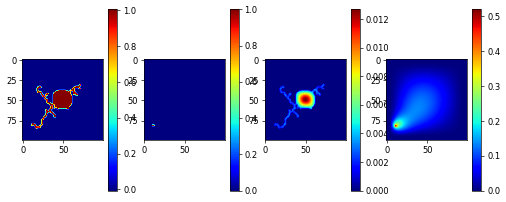

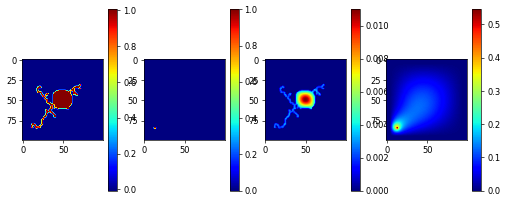

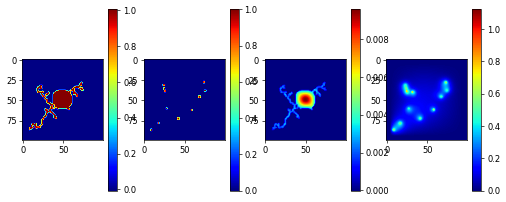

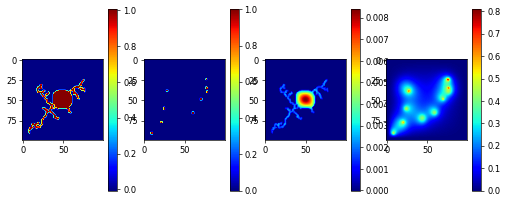

In [8]:
import matplotlib.pyplot as plt
hdf5_file = h5py.File(outputFolder+'/test_07032022.hdf5', mode='r')
ind = hdf5_file.get('phi')

id=0
numFrames=ind.shape[1]
numFrames = 30
for i in range(numFrames):
    plt.figure(figsize=(10, 4), dpi=60)
    plt.subplot(1,4,1)
    plt.imshow(ind[id,i,:,:,0],cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(ind[id,i,:,:,1],cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.imshow(ind[id,i,:,:,2],cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.imshow(ind[id,i,:,:,3],cmap='jet')
    plt.colorbar()
    plt.show()
hdf5_file.close()

In [ ]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import re
import copy

# function to expand the input matrix based on expd_size
def expd(original_mat, expd_size):
    sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
    output = np.zeros([expd_size,expd_size])
    output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    return output

# check and create output folder
import os
outputFolder = './data'
try:
    os.makedirs(outputFolder)
except:
    pass

# get all cases folder name
cases = glob.glob('../Matlab_simulation_data/case10*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

save_freq = 5000 # 0 for per10, 00 for per 100
len_iter = int(35000/save_freq)
ignore_iter = int(500/save_freq)
expd_size = 400 # target domain size
dwn = 20 # down sample ratio
dwn_sz = int(expd_size/dwn)
numCases = len(cases)

# hdf5_file = h5py.File(outputFolder+'/All_cases_'+str(int(dwn_sz))+'x'+str(int(dwn_sz))+'_per'+str(save_freq)+'_06222022.hdf5', mode='w')
hdf5_file = h5py.File(outputFolder+'/test.hdf5', mode='w')
hdf5_file.create_dataset("phi", (numCases, len_iter-ignore_iter+1, dwn_sz, dwn_sz, 2), np.float64, chunks=(1, 1, dwn_sz, dwn_sz, 1), compression="gzip")

phi_dwn = []
tips_dwn = []
for i in tqdm (range(len(cases)), desc="Running ..."):
    inputFolder = cases[i]
    case = inputFolder.replace('../Matlab_simulation_data/','')

    # load and expand theta
    thetaPath = glob.glob(inputFolder+'/theta_35000.mat')
    theta_temp = np.array(scipy.io.loadmat(thetaPath[0])['theta_plot'].todense())
    thetaExpd = expd(theta_temp, expd_size)
    # theta_dwn = thetaExpd[0::2,0::2]
    theta_dwn = thetaExpd[0::2,0::2]

    # defined input data folder and grab a list of data files
    phiPath = glob.glob(inputFolder+'/phi*0.mat')
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    # load and expand theta
    tipsPath = glob.glob(inputFolder+'/tips*0.mat')
    tipsPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    jj=0
    for j in range(len(phiPath)):
        s = phiPath[j]
        iter = int(s.replace('../Matlab_simulation_data/'+case+'/phi_','').replace('.mat',''))
        if ((iter % save_freq) == 0) and (iter > 500):

            # load data
            phi_temp = scipy.io.loadmat(s)['phi_plot']
            phi_temp = np.round(expd(phi_temp, expd_size))
            
            # phi_dwn = phi_temp[0::2,0::2]
            phi_dwn = phi_temp[0::dwn,0::dwn]
            hdf5_file["phi"][i, jj, :, :, 0] = phi_dwn
            # hdf5_file["phi"][i, jj, :, :, 0] = phi_dwn[50:150,50:150]

            tips_temp = np.array(scipy.io.loadmat(tipsPath[j])['theta_ori'])
            tips_temp = np.round(expd(tips_temp, expd_size))
            # tips_dwn = tips_temp[0::2,0::2]
            tips_dwn = tips_temp[0::dwn,0::dwn]

            hdf5_file["phi"][i, jj, :, :, 1] = tips_dwn
            # hdf5_file["phi"][i, jj, :, :, 1] = tips_dwn[50:150,50:150]

            jj+=1

hdf5_file.close()

In [ ]:
import h5py
h5 = h5py.File('./data/test.hdf5', mode='r')
ind = h5.get('phi')
ind.shape

In [ ]:
import matplotlib.pyplot as plt
id=0
numFrames=ind.shape[1]
numFrames = 30
for i in range(numFrames):
    plt.figure(figsize=(10, 4), dpi=60)
    plt.subplot(1,2,1)
    plt.imshow(ind[id,i,:,:,0],cmap='jet')
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(ind[id,i,:,:,1],cmap='jet')
    plt.colorbar()
    # plt.subplot(1,4,3)
    # plt.imshow(ind[id,i,:,:,2],cmap='jet')
    # plt.colorbar()
    # plt.subplot(1,4,4)
    # plt.imshow(ind[id,i,:,:,3],cmap='jet')
    # plt.colorbar()
    plt.show()
h5.close()

In [ ]:
import scipy.io
cm = scipy.io.loadmat('cm_100.mat')["cm"][0]
N1uNv = cm["N1uNv"][0].todense()
N1uNv.shape

In [ ]:
pp = ind[0,0,:,:,0]
plt.imshow(pp)

In [ ]:
import numpy as np
pp_N1uNv = N1uNv*np.reshape(pp,[100*100,1])
plt.imshow(np.reshape(pp_N1uNv,[100,100]))